# Topological Functions

In [21]:
from itertools import chain, combinations, permutations, product, pairwise
from math import prod, log
from copy import deepcopy
import networkx as nx
from fractions import Fraction
import json
from operator import add

def hs_array_to_fr(hs_array):
    return prod([pow(dims[d], hs_array[d]) for d in range(len(dims))])

def hs_array_to_cents(hs_array):
    return (1200 * log(hs_array_to_fr(hs_array), 2))

def expand_pitch(hs_array):
    expanded_pitch = list(hs_array)
    frequency_ratio = hs_array_to_fr(hs_array)
    if frequency_ratio < 1:
        while frequency_ratio < 1:
            frequency_ratio *= 2
            expanded_pitch[0] += 1
    elif frequency_ratio >= 2:
        while frequency_ratio >= 2:
            frequency_ratio *= 1/2
            expanded_pitch[0] += -1
    return tuple(expanded_pitch)

def expand_chord(chord):
    return tuple(expand_pitch(p) for p in chord)

def collapse_pitch(hs_array):
    collapsed_pitch = list(hs_array)
    collapsed_pitch[0] = 0
    return tuple(collapsed_pitch)

def collapse_chord(chord):
    return tuple(collapse_pitch(p) for p in chord)

def transpose_pitch(pitch, trans):
    return tuple(map(add, pitch, trans))

def transpose_chord(chord, trans):
    return tuple(transpose_pitch(p, trans) for p in chord)

def cent_difference(hs_array1, hs_array2):
    return hs_array_to_cents(hs_array2) - hs_array_to_cents(hs_array1)

def pitch_difference(hs_array1, hs_array2):
    return transpose_pitch(hs_array1, [p * -1 for p in hs_array2])

# this is modified for different chord sizes like original version
def grow_chords(chord, root, min_chord_size, max_chord_size):
    #this could use the tranpose_pitch function
    branches = [branch for alt in [-1, 1] for d in range(1, len(root)) if (branch:=(*(r:=root)[:d], r[d] + alt, *r[(d + 1):])) not in chord]
    subsets = chain.from_iterable(combinations(branches, r) for r in range(1, max_chord_size - len(chord) + 1))
    for subset in subsets:
        extended_chord = chord + subset
        if(len(extended_chord) < max_chord_size):
            for branch in subset:
                yield from grow_chords(extended_chord, branch, min_chord_size, max_chord_size)
        if(len(extended_chord) >= min_chord_size):
            yield tuple(sorted(extended_chord, key=hs_array_to_fr))

def chords(chord, root, min_chord_size, max_chord_size):
    # this will filter out the 4x dups of paths that are loops, there might be a faster way to test this
    return set(grow_chords(chord, root, min_chord_size, max_chord_size))

# this is very slow, I have an idea in mind that my be faster by simply growing the chords to max_chord_size + max_sim_diff
# technically at that point you have generated both chords and can get the second chord from the first
def edges(chords, min_symdiff, max_symdiff, max_chord_size):  

    def reverse_movements(movements):
        return {value['destination']:{'destination':key, 'cent_difference':value['cent_difference'] * -1} for key, value in movements.items()}

    def is_directly_tunable(intersection, diff):
        # this only works for now when intersection if one element - need to fix that
        return max([sum(abs(p) for p in collapse_pitch(pitch_difference(d, list(intersection)[0]))) for d in diff]) == 1

    for combination in combinations(chords, 2):
        [expanded_base, expanded_comp] = [expand_chord(chord) for chord in combination]
        edges = []
        transpositions = set(pitch_difference(pair[0], pair[1]) for pair in set(product(expanded_base, expanded_comp)))
        for trans in transpositions:
            expanded_comp_transposed = transpose_chord(expanded_comp, trans)
            intersection = set(expanded_base) & set(expanded_comp_transposed)
            symdiff_len = sum([len(chord) - len(intersection) for chord in [expanded_base, expanded_comp_transposed]])
            if (min_symdiff <= symdiff_len <= max_symdiff):
                rev_trans = tuple(t * -1 for t in trans)
                [diff1, diff2] = [list(set(chord) - intersection) for chord in [expanded_base, expanded_comp_transposed]]
                base_map = {val: {'destination':transpose_pitch(val, rev_trans), 'cent_difference': 0} for val in intersection}
                base_map_rev = reverse_movements(base_map)
                maps = []
                diff1 += [None] * (max_chord_size - len(diff1) - len(intersection))
                perms = [list(perm) + [None] * (max_chord_size - len(perm) - len(intersection)) for perm in set(permutations(diff2))]
                for p in perms:
                    appended_map = {
                        diff1[index]:
                        {
                            'destination': transpose_pitch(val, rev_trans) if val != None else None, 
                            'cent_difference': cent_difference(diff1[index], val) if None not in [diff1[index], val] else None
                        } for index, val in enumerate(p)}
                    yield (tuple(expanded_base), tuple(expanded_comp), {
                        'transposition': trans,
                        'symmetric_difference': symdiff_len, 
                        'is_directly_tunable': is_directly_tunable(intersection, diff2),
                        'movements': base_map | appended_map
                    },)
                    yield (tuple(expanded_comp), tuple(expanded_base), {
                        'transposition': rev_trans,
                        'symmetric_difference': symdiff_len, 
                        'is_directly_tunable': is_directly_tunable(intersection, diff1),
                        'movements': base_map_rev | reverse_movements(appended_map)
                    },)

def graph_from_edges(edges):
    g = nx.MultiDiGraph()
    g.add_edges_from(edges)
    return g

def generate_graph(chord_set, min_symdiff, max_symdiff, max_chord_size):
    #chord_set = chords(pitch_set, min_chord_size, max_chord_size)
    edge_set = edges(chord_set, min_symdiff, max_symdiff, max_chord_size)
    res_graph = graph_from_edges(edge_set)
    return res_graph

def display_graph(graph):
    show_graph = nx.Graph(graph)
    pos = nx.draw_spring(show_graph, node_size=5, width=0.1)
    plt.figure(1, figsize=(12,12)) 
    nx.draw(show_graph, pos, node_size=5, width=0.1)
    plt.show()
    #plt.savefig('compact_sets.png', dpi=150)

def path_to_chords(path, start_root):
    current_root = start_root
    start_chord = tuple(sorted(path[0][0], key=hs_array_to_fr))
    chords = ((start_chord, start_chord,),)
    for edge in path:
        trans = edge[2]['transposition']
        movements = edge[2]['movements']
        current_root = transpose_pitch(current_root, trans)
        current_ref_chord = chords[-1][0]
        next_ref_chord = tuple(movements[pitch]['destination'] for pitch in current_ref_chord)
        next_transposed_chord = tuple(transpose_pitch(pitch, current_root) for pitch in next_ref_chord)
        chords += ((next_ref_chord, next_transposed_chord,),)
    return tuple(chord[1] for chord in chords)

def write_chord_sequence(path):
    file = open("seq.txt", "w+")
    content = json.dumps(path)
    content = content.replace("[[[", "[\n\t[[")
    content = content.replace(", [[", ",\n\t[[")
    content = content.replace("]]]", "]]\n]")
    file.write(content)
    file.close()

# This is the static version, which will be the middle piece

## path functions

In [2]:
from random import choice, choices

# This is for the static version
def stochastic_hamiltonian(graph):
        
    def movement_size_weights(edges):
        
        def max_cent_diff(edge):
            res = max([abs(v) for val in edge[2]['movements'].values() if (v:=val['cent_difference']) is not None])
            return res
            
        def min_cent_diff(edge):
            res = [abs(v) for val in edge[2]['movements'].values() if (v:=val['cent_difference']) is not None]
            res.remove(0)
            return min(res)
            
        for e in edges:
            yield 1000 if ((max_cent_diff(e) < 200) and (min_cent_diff(e)) > 50) else 1

    def hamiltonian_weights(edges):
        for e in edges:
            yield 10 if e[1] not in [path_edge[0] for path_edge in path] else 1 / graph.nodes[e[1]]['count']
    
    def contrary_motion_weights(edges):

        def is_contrary(edge):
            cent_diffs = [v for val in edge[2]['movements'].values() if (v:=val['cent_difference']) is not None]
            cent_diffs.sort()
            return (cent_diffs[0] < 0) and (cent_diffs[1] == 0) and (cent_diffs[2] > 0)

        for e in edges:
            yield 10 if is_contrary(e) else 1
    
    def is_directly_tunable_weights(edges):
        for e in edges:
            yield 10 if e[2]['is_directly_tunable'] else 0

    def voice_crossing_weights(edges):
        
        def has_voice_crossing(edge):
            source = list(edge[0])
            ordered_source = sorted(source, key=hs_array_to_fr)    
            source_order = [ordered_source.index(p) for p in source]
            destination = [transpose_pitch(edge[2]['movements'][p]['destination'], edge[2]['transposition']) for p in source]
            ordered_destination = sorted(destination, key=hs_array_to_fr)
            destination_order = [ordered_destination.index(p) for p in destination]
            return source_order != destination_order

        for e in edges:
            yield 10 if not has_voice_crossing(e) else 0

    def is_bass_rooted(chord):
        return max([sum(abs(p) for p in collapse_pitch(pitch_difference(chord[0], p))) for p in chord[1:]]) == 1
        
    check_graph = graph.copy()
    next_node = choice([node for node in graph.nodes() if is_bass_rooted(node)])
    check_graph.remove_node(next_node)
    for node in graph.nodes(data=True):
        node[1]['count'] = 1
    path = []
    while (nx.number_of_nodes(check_graph) > 0) and (len(path) < 5000):
        out_edges = list(graph.out_edges(next_node, data=True))
        factors = [
            movement_size_weights(out_edges), 
            hamiltonian_weights(out_edges), 
            contrary_motion_weights(out_edges), 
            is_directly_tunable_weights(out_edges),
            voice_crossing_weights(out_edges)
        ]
        weights = [prod(a) for a in zip(*factors)]
        edge = choices(out_edges, weights=weights)[0]
        #edge = random.choice(out_edges)
        next_node = edge[1]
        node[1]['count'] += 1
        path.append(edge)
        if next_node in check_graph.nodes:
            check_graph.remove_node(next_node)
    return path

## model

In [3]:
dims = (2, 3, 5, 7, 11)
root = (0, 0, 0, 0, 0)
chord = (root,)
chord_set = chords(chord, root, 3, 3)
graph = generate_graph(chord_set, 4, 4, 3)

In [4]:
path = stochastic_hamiltonian(graph)
#for edge in path:
#    print(edge)
write_chord_sequence(path_to_chords(path, root))

## profiling 

In [11]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [134]:
chord_set = chords(chord, root, 3, 3)

In [136]:
lprun -f edge_data edges(chord_set, 3, 3, 4)

Timer unit: 1e-09 s

Total time: 0.112228 s
File: /tmp/ipykernel_515812/2679284550.py
Function: edge_data at line 74

Line #      Hits         Time  Per Hit   % Time  Line Contents
    74                                           def edge_data(chords, min_symdiff, max_symdiff, max_chord_size):
    75       990   29603044.0  29902.1     26.4      [expanded_base, expanded_comp] = [expand_chord(chord) for chord in chords]
    76       990     229527.0    231.8      0.2      edges = []
    77       990   23648371.0  23887.2     21.1      transpositions = set(pitch_difference(pair[0], pair[1]) for pair in set(product(expanded_base, expanded_comp)))
    78      9193    2315267.0    251.9      2.1      for trans in transpositions:
    79      8203   33386775.0   4070.1     29.7          expanded_comp_transposed = transpose_chord(expanded_comp, trans)
    80      8203    8393773.0   1023.3      7.5          intersection = set(expanded_base) & set(expanded_comp_transposed)
    81      8203   11

# This is for the rising version/yitgadal, which will be either the last of the 3 pieces (with option of the pieces played in reverse)

## path functions

In [5]:
from random import choice, choices

# This is for the rising version / yitgadal
def stochastic_hamiltonian(graph):
        
    def movement_size_weights(edges):
        
        def max_cent_diff(edge):
            res = max([v for val in edge[2]['movements'].values() if (v:=val['cent_difference']) is not None])
            return res
            
        def min_cent_diff(edge):
            res = [v for val in edge[2]['movements'].values() if (v:=val['cent_difference']) is not None]
            res.remove(0)
            return min(res)
            
        for e in edges:
            yield 1000 if ((max_cent_diff(e) < 175) and (min_cent_diff(e)) >= 0) else 1

    def hamiltonian_weights(edges):
        for e in edges:
            yield 10 if e[1] not in [path_edge[0] for path_edge in path] else 1 / graph.nodes[e[1]]['count']
    
    def contrary_motion_weights(edges):

        def is_contrary(edge):
            cent_diffs = [v for val in edge[2]['movements'].values() if (v:=val['cent_difference']) is not None]
            cent_diffs.sort()
            return (cent_diffs[0] < 0) and (cent_diffs[1] == 0) and (cent_diffs[2] > 0)

        for e in edges:
            yield 2 if is_contrary(e) else 1
    
    def is_directly_tunable_weights(edges):
        for e in edges:
            yield 10 if e[2]['is_directly_tunable'] else 0

    def transposition_weight(edges):
        for e in edges:
            yield 1000 if 0 <= hs_array_to_cents(e[2]['transposition']) < 100 else 0

    def is_sustained_voice(edges, voice):
        
        def is_sustained(edge):
            source = list(edge[0])
            ordered_source = sorted(source, key=hs_array_to_fr)    
            destination = [transpose_pitch(edge[2]['movements'][p]['destination'], edge[2]['transposition']) for p in source]
            ordered_destination = sorted(destination, key=hs_array_to_fr)
            return ordered_source[voice] == ordered_destination[voice]

        for e in edges:
            yield 10 if is_sustained(e) else 0

    def voice_crossing_weights(edges):
        
        def has_voice_crossing(edge):
            source = list(edge[0])
            ordered_source = sorted(source, key=hs_array_to_fr)    
            source_order = [ordered_source.index(p) for p in source]
            destination = [transpose_pitch(edge[2]['movements'][p]['destination'], edge[2]['transposition']) for p in source]
            ordered_destination = sorted(destination, key=hs_array_to_fr)
            destination_order = [ordered_destination.index(p) for p in destination]
            return source_order != destination_order

        for e in edges:
            yield 10 if not has_voice_crossing(e) else 0

    def is_bass_rooted(chord):
        return max([sum(abs(p) for p in collapse_pitch(pitch_difference(chord[0], p))) for p in chord[1:]]) == 1
        
    check_graph = graph.copy()
    #next_node = choice([node for node in graph.nodes() if is_bass_rooted(node)])
    next_node = choice(list(graph.nodes()))
    print(next_node)
    check_graph.remove_node(next_node)
    for node in graph.nodes(data=True):
        node[1]['count'] = 1
    path = []
    while (nx.number_of_nodes(check_graph) > 0) and (len(path) < 500):
        out_edges = list(graph.out_edges(next_node, data=True))
        #print([l for l in zip(movement_size_weights(out_edges), hamiltonian_weights(out_edges))])
        factors = [
            movement_size_weights(out_edges), 
            hamiltonian_weights(out_edges), 
            voice_crossing_weights(out_edges),
            #contrary_motion_weights(out_edges), 
            #is_directly_tunable_weights(out_edges),
            #transposition_weight(out_edges)
            #is_sustained_voice(out_edges, 0)
        ]
        weights = [prod(a) for a in zip(*factors)]
        edge = choices(out_edges, weights=weights)[0]
        next_node = edge[1]
        node[1]['count'] += 1
        path.append(edge)
        if next_node in check_graph.nodes:
            check_graph.remove_node(next_node)
    print(len(check_graph.nodes()))
    return path

## model

In [8]:
dims = (2, 3, 5, 7, 11)
root = (0, 0, 0, 0, 0)
chord = (root,)
chord_set = chords(chord, root, 3, 3)
graph = generate_graph(chord_set, 2, 2, 3)

In [9]:
path = stochastic_hamiltonian(graph)
#for edge in path:
#    print(edge)
write_chord_sequence(path_to_chords(path, root))
len(path)

((3, 0, -1, 0, 0), (2, -1, 0, 0, 0), (0, 0, 0, 0, 0))
0


178

# This is for the beginning/breysheet, which will be the first of the set of 3 (with option in reverse)

## functions for analyzing a recording and filtering the data

In [3]:
#ffmpeg -i video.mkv -acodec pcm_s16le -ar 16000 -ac 2 bereshit_chant.wav
#sox bereshit_chant.wav bereshit_chant_snippet.wav trim 4 60

In [22]:
import crepe
from scipy.io import wavfile

In [23]:
sr, audio = wavfile.read('/home/mwinter/Downloads/bereshit_chant_snippet.wav')

In [24]:
time, frequency, confidence, activation = crepe.predict(audio, sr, step_size = 25)
#time, frequency, confidence = [list(time), list(frequency), list(confidence)]

76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 292ms/step


## legacy stuff

In [14]:
import librosa 
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from random import randint

def filter_data(time, frequency, confidence):
    data = tuple(data for data in zip(list(time), list(frequency), list(confidence)) if data[2] > 0.1)
    dev = 0
    dur = 0
    for (p1, p2) in pairwise(data):
        t_diff = (p2[0] - p1[0])
        dur = round(dur + (p2[0] - p1[0]), 2)
        if(True):
            freq1, conf1 = p1[1:3]
            midi1 = librosa.hz_to_midi(freq1)
            r_midi1 = np.around(midi1)
            freq2, conf2 = p2[1:3]
            midi2 = librosa.hz_to_midi(freq2)
            r_midi2 = np.around(midi2)
            #if(r_midi2 != r_midi1):
            if(True):
                yield(dur, freq1, conf1, midi1, r_midi1, dev * 100)
                dev = r_midi2 - r_midi1
                dur = 0

def filter_data(time, frequency, confidence):
    data = tuple(data for data in zip(list(time), list(frequency), list(confidence)) if data[2] > 0.9)
    #durs = tuple(round(y[0]-x[0], 2) for (x, y) in pairwise(data)) + ((1,))
    #data = tuple((d,) + data[i][1:] for i, d in enumerate(durs) if d > 0.01)
    #print(data)
    m, rm = [librosa.hz_to_midi(data[0][1]), np.around(librosa.hz_to_midi(data[0][1]))]
    yield(data[0] + (m, rm, 0,))
    for i, [t, f, c] in enumerate(data):
        nm, nrm = [librosa.hz_to_midi(f), np.around(librosa.hz_to_midi(f))]
        if((0 < i < len(data) - 1) and (nrm != rm)):
            m, rm, d = [nm, nrm, nrm - rm]
            yield(t, f, c, m, rm, d * 100)
            
t_min = 50
t_max = 600
f_time, f_frequency, f_confidence = [time[t_min:], frequency[t_min:], confidence[t_min:]]
s_confidence = savgol_filter(f_confidence, 30, 4)
#plt.plot(f_time, f_confidence)
#plt.plot(f_time, s_confidence, color='red')
#plt.show()

def freqs_to_midi(freqs, confs):
    last_confident_value = 51
    for f, c in zip(freqs, confs):
        if c > 0.9:
            last_confident_value = librosa.hz_to_midi(f)
        yield last_confident_value
            
#m_time, midi = zip(*[[t, librosa.hz_to_midi(f)] for t, f, c in zip(f_time, f_frequency, s_confidence) if c > 0.0])
#nr_midi = np.interp(f_time, m_time, midi)
#r_midi = np.interp(f_time, m_time, np.around(midi))
#midi

#data_v2 = tuple(d + (2,) for d in zip(f_time, f_frequency, s_confidence))
#data_v1 = tuple(d + (1,) for d in zip([t + 2 for t in f_time], f_frequency, s_confidence))
#data_v0 = tuple(d + (0,) for d in zip([t + 4 for t in f_time], f_frequency, s_confidence))

#data = data_v2 + data_v1 + data_v0
#data = sorted(data)
#f_time = tuple(d[0] for d in data)
#ins = tuple(d[-1] for d in data)

def snap_midi(midi):
    r_midi = np.around(midi)
    s_midi = np.around(savgol_filter(midi, 30, 5))
    last_val = s_midi[0]
    for i, (r1, r2) in enumerate(pairwise(r_midi)):
        if r1 != r2:
            last_val = s_midi[i+5]
        yield last_val
    yield last_val

def format_midi(midi):
    last_val = midi[0]
    dur = 1
    dev = 0.0
    first_flag = True
    for i, (m1, m2) in enumerate(pairwise(midi)):
        if m1 != m2:
            #yield (dur / 40, last_val, dev * 100)
            if first_flag or dur < 10:
                yield (10 / 40.0, last_val, dev * 100)
                first_flag = False
            else:
                size = int(dur / 20)
                
                #sep = randint(1, size)
                #yield (10 / 40.0 * sep, last_val, dev * 100)
                #yield (10 / 40.0 * (size - sep), last_val, 0.0)

                b_dur = randint(5, 10)
                yield (randint(10, 20) / 40.0, last_val, dev * 100)
                for i in range(size):
                    yield (randint(10, 20) / 40.0, last_val, 0.0)
                    
            last_val = m2
            dur = 1
            dev = m2 - m1
        else:
            dur += 1

#need to figure out how to make each note hold for a bit and then release
def filter_midi(midi):
    last_val = midi[0][-1]
    ins = 2
    dur = 1
    total_dur = 0
    dev = 0.0
    remaining_durs = [100, 100, 100]
    first_flag = True
    for i, (m1, m2) in enumerate(pairwise(midi)):
        if m1 != m2:
            #print([m1, m2])
            #print(last_val)
            #print(ins)
            #yield (dur / 40, last_val, ins, dev * 100)

            if first_flag or dur < 20:
                allowed_ins = (ins,)
                print((10 / 40.0, last_val, ins, allowed_ins, dev * 100))
                yield (10 / 40.0, last_val, ins, allowed_ins, dev * 100)
                first_flag = False
            else:
                size = int(dur / 10) 

                #b_dur = randint(1, size)
                #yield ((b_dur * 10) / 40.0, last_val, ins, dev * 100)
                #yield (((size - b_dur) * 10) / 40.0, last_val, ins, 0)

                #yield (((size - 1) * 10) / 40.0, last_val, ins, dev * 100)
                #yield (10 / 40.0, last_val, ins, 0)

                #allowed_ins = tuple(ibx for ibx, r_dur in enumerate(remaining_durs) if r_dur < 20 or ibx == ins)
                allowed_ins = (ins,)
                yield (randint(5, 10) / 40.0, last_val, ins, allowed_ins, dev * 100)
                print((randint(5, 10) / 40.0, last_val, ins, allowed_ins, dev * 100))
                for irx in range(size - 1):
                    allowed_ins = tuple(ibx for ibx, r_dur in enumerate(remaining_durs) if r_dur < 20 and ibx != ins)
                    yield (randint(5, 10) / 40.0, last_val, ins, allowed_ins, 0.0)
                    print((randint(5, 10) / 40.0, last_val, ins, allowed_ins, 0.0))

            remaining_durs[ins] = 0
            print(ins)
            print(midi[i + remaining_durs[ins]])
            print(midi[i + 1 + remaining_durs[ins]])
            while midi[i + 1 + remaining_durs[ins]][ins] == midi[i + 2 + remaining_durs[ins]][ins] and midi[total_dur + 2 + remaining_durs[ins]][ins] < len(midi):
                remaining_durs[ins] += 1

            ins = [imx for imx, m in enumerate(m1) if m1[imx] != m2[imx]][0]
            #ins = 2
            dur = 1
            dev = m2[ins] - last_val
            last_val = m2[ins]
        else:
            dur += 1
            remaining_durs = [r_dur - 1 for r_dur in remaining_durs]
        print(remaining_durs)
        print(midi[i])
        total_dur += 1

def filter_midi(midi):
    remainder_durs = [1000, 1000, 1000]
    for imx, m in enumerate(midi):
        if m != midi[imx - 1]:
            if imx == 0:
                ins = 2
                val = m[2]
                last_val = val
            else:
                ins = [pmx for pmx, p in enumerate(m) if p != midi[imx - 1][pmx]][0]
                val = m[ins]
            note_dur = 0
            print(ins)
            print(val)
            while imx + note_dur < len(midi) and midi[imx + note_dur][ins] == val:
                note_dur += 1
            next_dur = 0
            while imx + next_dur < len(midi) and midi[imx + next_dur] == m:
                next_dur += 1
            remainder_durs[ins] = note_dur - next_dur
            dev = val - last_val
            allowed_ins = (0,)
            
            yield (next_dur / 40.0, val, ins, allowed_ins, dev * 100)
            
            last_val = val
            remainder_durs = [rd - 1 for rd in remainder_durs]
    
midi = list(freqs_to_midi(f_frequency, f_confidence))

#plt.plot(f_time, midi)
#plt.plot(f_time, savgol_filter(midi, 30, 5), color='yellow')
#plt.plot(f_time, np.around(savgol_filter(midi, 30, 5)), color='red')
#plt.plot(f_time, np.around(midi), color='green')
#plt.plot(f_time, list(snap_midi(midi)), color='blue')
#plt.show()

midi = tuple(snap_midi(midi))

#print(len(midi))
#print(midi)

fs = 2351 # sample rate 
f = 20 # the frequency of the signal

#midi = zip(
#    tuple(midi[0] - 12 for i in range(2 * 40)) + tuple(chain(*tuple([m - 12 for r in range(randint(2, 4))] for m in midi))),
#    tuple(midi[0] - 7 for i in range(1 * 40)) + tuple(chain(*tuple([m - 7 for r in range(randint(1, 3))] for m in midi))) + tuple(midi[-1] - 12 for i in range(5 * 40)),
#    tuple(chain(*tuple([m for r in range(int(1 - np.cos(2*np.pi*f * (imx/fs))) * 5 + 1)] for imx, m in enumerate(midi)))) + tuple(midi[-1] - 0 for i in range(10 * 40)))

midi = zip(
    tuple(midi[0] - 12 for i in range(2 * 40)) + tuple(chain(*tuple([m - 12 for r in range(int(1 - np.sin(2*np.pi*14 * (imx/fs))) * 3 + 1)] for imx, m in enumerate(midi)))),
    tuple(midi[0] - 7 for i in range(1 * 40)) + tuple(chain(*tuple([m - 7 for r in range(int(1 - np.sin(2*np.pi*12 * (imx/fs))) * 3 + 1)] for imx, m in enumerate(midi)))),
    tuple(chain(*tuple([m for r in range(int(1 - np.cos(0.5 * np.pi + 2*np.pi*10 * (imx/fs))) * 3 + 1)] for imx, m in enumerate(midi))))
)

#for m in list(midi):
#    print(m)

target_melody_data = list(filter_midi(list(midi)))
target_melody_data


#target_melody_data = list(filter_data(time, frequency, confidence))
#target_melody_data
#durs = tuple(round(y[0]-x[0], 2) for (x, y) in pairwise(target_melody_data)) + ((1,))
#print(durs)
#target_melody_data = tuple((d,) + target_melody_data[i][1:] for i, d in enumerate(durs) if d > 0.1)
#list(target_melody_data)

2
51.0
1
46.0
1
44.0
0
41.0
0
39.0
2
53.0
1
42.0
2
51.0
1
41.0
0
37.0
0
36.0
1
42.0
2
49.0
2
48.0
0
37.0
2
49.0
0
39.0
1
44.0
2
51.0
0
40.0
0
39.0
1
44.0
2
52.0
2
51.0
1
42.0
1
41.0
0
37.0
0
36.0
1
44.0
2
49.0
2
48.0
1
46.0
0
39.0
1
44.0
2
51.0
0
41.0
0
39.0
2
53.0
0
40.0
1
45.0
2
51.0
1
41.0
0
36.0
1
46.0
2
52.0
2
48.0
1
44.0
1
42.0
2
53.0
0
41.0
2
51.0
0
39.0
0
37.0
2
49.0
0
40.0
0
41.0
0
40.0
1
45.0
1
46.0
0
39.0
1
45.0
1
44.0
1
45.0
1
44.0
1
42.0
1
41.0
1
39.0
0
40.0
0
39.0
2
52.0
2
53.0
2
52.0
0
37.0
2
51.0
0
36.0
2
52.0
2
51.0
2
49.0
2
48.0
0
34.0
2
46.0
1
44.0
1
45.0
2
51.0
2
52.0
0
39.0
0
40.0
0
42.0
0
44.0
0
45.0
1
47.0
1
49.0
1
50.0
2
54.0
0
41.0
2
56.0
2
57.0
1
46.0
1
50.0
1
48.0
1
47.0
1
44.0
2
53.0
0
45.0
0
43.0
0
42.0
0
39.0
2
57.0
2
55.0
2
54.0
2
51.0
0
41.0
1
46.0
2
53.0
0
39.0
1
44.0
2
51.0
1
42.0
1
41.0
0
37.0
0
36.0
1
42.0
0
37.0
1
44.0
0
39.0
2
49.0
2
48.0
2
49.0
2
51.0
2
50.0
1
43.0
2
52.0
2
53.0
1
45.0
1
46.0
0
38.0
0
40.0
0
41.0
1
44.0
1
48.0
1
50.0
1
49.0
2
55.0

[(2.125, 51.0, 2, (0,), 0.0),
 (0.3, 46.0, 1, (0,), -500.0),
 (0.7, 44.0, 1, (0,), -200.0),
 (0.3, 41.0, 0, (0,), -300.0),
 (0.7, 39.0, 0, (0,), -200.0),
 (1.0, 53.0, 2, (0,), 1400.0),
 (0.2, 42.0, 1, (0,), -1100.0),
 (1.5, 51.0, 2, (0,), 900.0),
 (0.35, 41.0, 1, (0,), -1000.0),
 (1.7, 37.0, 0, (0,), -400.0),
 (1.85, 36.0, 0, (0,), -100.0),
 (0.6, 42.0, 1, (0,), 600.0),
 (0.725, 49.0, 2, (0,), 700.0),
 (0.575, 48.0, 2, (0,), -100.0),
 (0.4, 37.0, 0, (0,), -1100.0),
 (0.325, 49.0, 2, (0,), 1200.0),
 (0.05, 39.0, 0, (0,), -1000.0),
 (0.35, 44.0, 1, (0,), 500.0),
 (0.225, 51.0, 2, (0,), 700.0),
 (0.05, 40.0, 0, (0,), -1100.0),
 (0.05, 39.0, 0, (0,), -100.0),
 (0.3, 44.0, 1, (0,), 500.0),
 (0.05, 52.0, 2, (0,), 800.0),
 (0.75, 51.0, 2, (0,), -100.0),
 (0.05, 42.0, 1, (0,), -900.0),
 (1.25, 41.0, 1, (0,), -100.0),
 (0.2, 37.0, 0, (0,), -400.0),
 (0.8, 36.0, 0, (0,), -100.0),
 (0.6, 44.0, 1, (0,), 800.0),
 (0.2, 49.0, 2, (0,), 500.0),
 (1.8, 48.0, 2, (0,), -100.0),
 (0.5, 46.0, 1, (0,), -200

[   0    1    2 ... 2348 2349 2350]


range(0, 1)

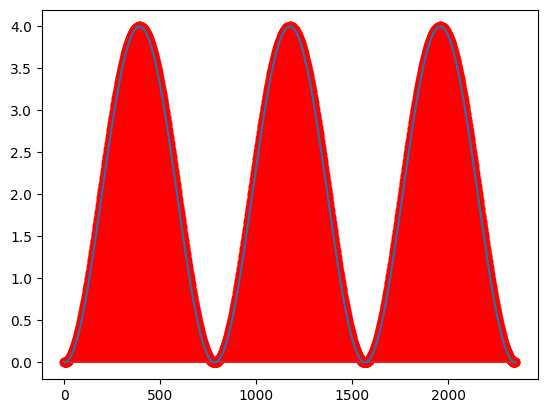

In [33]:
import matplotlib.pyplot as plt # For ploting
import numpy as np # to work with numerical data efficiently

fs = 2351 # sample rate 
f = 3 # the frequency of the signal

x = np.arange(fs) # the points on the x axis for plotting
print(x)
# compute the value (amplitude) of the sin wave at the for each sample
y = (1 - np.sin(0.5 * np.pi + 2*np.pi*f * ((x)/fs))) * 2 + 0

#this instruction can only be used with IPython Notbook. 
# showing the exact location of the smaples
plt.stem(x,y, 'r', )
plt.plot(x,y)
np.cos(2*np.pi*f * (10/fs)) * 1 + 2
range(int((1 - np.sin(2*np.pi*f * (50/fs))) *  + 2))

## cleanup (this is what is being used)

In [151]:
import librosa 
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from random import randint

            
t_min = 50
t_max = 600
f_time, f_frequency, f_confidence = [time[t_min:], frequency[t_min:], confidence[t_min:]]
s_confidence = savgol_filter(f_confidence, 30, 4)

def freqs_to_midi(freqs, confs):
    last_confident_value = 51
    for f, c in zip(freqs, confs):
        if c > 0.9:
            last_confident_value = librosa.hz_to_midi(f)
        yield last_confident_value

def snap_midi(midi):
    r_midi = np.around(midi)
    s_midi = np.around(savgol_filter(midi, 30, 5))
    last_val = s_midi[0]
    for i, (r1, r2) in enumerate(pairwise(r_midi)):
        if r1 != r2:
            last_val = s_midi[i+5]
        yield last_val
    yield last_val

def filter_midi(midi):

    def integrate(midi):
        print(len(midi) / 40)
        for imx, m in enumerate(midi):
            if m != midi[imx - 1] or imx == 0:
                if imx == 0:
                    ins = 2
                    val = m[2]
                    last_val = val
                else:
                    ins = [pmx for pmx, p in enumerate(m) if p != midi[imx - 1][pmx]][0]
                    val = m[ins]
                note_dur = 0
                #print(ins)
                #print(val)
                while imx + note_dur < len(midi) and midi[imx + note_dur][ins] == val:
                    note_dur += 1
                dev = val - last_val

                print (imx / 40.0, val, ins, val)
                print(note_dur / 40.0)
                yield (imx / 40.0, val, ins, val)

                tail = randint(20, 40)
                if note_dur / 2 > tail:
                #if False:
                    t_sum = 0
                    while t_sum < tail:
                        print("here")
                        print ((imx + note_dur - tail + t_sum) / 40, val, ins, None)
                        print(note_dur / 40.0)
                        yield ((imx + note_dur - tail + t_sum) / 40, val, ins, None)
                        t_sum += randint(10, 15)
                
                last_val = val

    def redifferentiate(sorted_midi):
        for imx, sm in enumerate(sorted_midi):
            print("---")
            print(sm)
            if imx < len(sorted_midi) - 1:
                dur = round(sorted_midi[imx + 1][0] - sm[0], 3)
            else:
                dur = 40
            [val, ins] = sm[1:-1]
            dev = 0
            if imx == 0:
                dev = 0.0
                last_val = val
            elif sm[-1] == None:
                dev = None
            else:
                dev = (sm[-1] - last_val) * 100.0
                last_val = val
            print((dur, val, ins, dev))
            yield (dur, val, ins, dev)
                
    sorted_midi = sorted(integrate(midi))
    #for sm in sorted_midi:
    #    print(sm)
    redifferentiated_midi = redifferentiate(sorted_midi)
    return redifferentiated_midi
    
midi = list(freqs_to_midi(f_frequency, f_confidence))
midi = tuple(snap_midi(midi))

fs = 2351 # sample rate 
f = 20 # the frequency of the signal

midi = zip(
    tuple(midi[0] - 12 for i in range(2 * 40)) + tuple(chain(*tuple([m - 12 for r in range(int(1 - np.sin(2*np.pi*14 * (imx/fs))) * 3 + 1)] for imx, m in enumerate(midi)))),
    tuple(midi[0] - 7 for i in range(1 * 40)) + tuple(chain(*tuple([m - 7 for r in range(int(1 - np.sin(2*np.pi*12 * (imx/fs))) * 3 + 1)] for imx, m in enumerate(midi)))),
    tuple(chain(*tuple([m for r in range(int(1 - np.cos(0.5 * np.pi + 2*np.pi*10 * (imx/fs))) * 3 + 1)] for imx, m in enumerate(midi))))
)

target_melody_data = list(filter_midi(list(midi)))
target_melody_data


146.9
0.0 51.0 2 51.0
4.125
here
3.175 51.0 2 None
4.125
here
3.5 51.0 2 None
4.125
here
3.875 51.0 2 None
4.125
2.125 46.0 1 46.0
0.3
2.425 44.0 1 44.0
2.7
here
4.575 44.0 1 None
2.7
here
4.9 44.0 1 None
2.7
3.125 41.0 0 41.0
0.3
3.425 39.0 0 39.0
3.75
here
6.4 39.0 0 None
3.75
here
6.775 39.0 0 None
3.75
here
7.075 39.0 0 None
3.75
4.125 53.0 2 53.0
1.2
5.125 42.0 1 42.0
1.7
here
6.075 42.0 1 None
1.7
here
6.45 42.0 1 None
1.7
here
6.7 42.0 1 None
1.7
5.325 51.0 2 51.0
6.0
here
10.8 51.0 2 None
6.0
here
11.175 51.0 2 None
6.0
6.825 41.0 1 41.0
3.9
here
9.975 41.0 1 None
3.9
here
10.275 41.0 1 None
3.9
here
10.525 41.0 1 None
3.9
7.175 37.0 0 37.0
1.7
here
8.25 37.0 0 None
1.7
here
8.5 37.0 0 None
1.7
here
8.75 37.0 0 None
1.7
8.875 36.0 0 36.0
3.75
here
12.1 36.0 0 None
3.75
here
12.425 36.0 0 None
3.75
10.725 42.0 1 42.0
2.675
here
12.7 42.0 1 None
2.675
here
12.975 42.0 1 None
2.675
here
13.35 42.0 1 None
2.675
11.325 49.0 2 49.0
0.725
12.05 48.0 2 48.0
0.975
12.625 37.0 0 37.0
0.7

[(2.125, 51.0, 2, 0.0),
 (0.3, 46.0, 1, -500.0),
 (0.7, 44.0, 1, -200.0),
 (0.05, 41.0, 0, -300.0),
 (0.25, 51.0, 2, None),
 (0.075, 39.0, 0, -200.0),
 (0.375, 51.0, 2, None),
 (0.25, 51.0, 2, None),
 (0.45, 53.0, 2, 1400.0),
 (0.325, 44.0, 1, None),
 (0.225, 44.0, 1, None),
 (0.2, 42.0, 1, -1100.0),
 (0.75, 51.0, 2, 900.0),
 (0.325, 42.0, 1, None),
 (0.05, 39.0, 0, None),
 (0.25, 42.0, 1, None),
 (0.075, 42.0, 1, None),
 (0.05, 39.0, 0, None),
 (0.25, 41.0, 1, -1000.0),
 (0.1, 39.0, 0, None),
 (1.075, 37.0, 0, -400.0),
 (0.25, 37.0, 0, None),
 (0.25, 37.0, 0, None),
 (0.125, 37.0, 0, None),
 (1.1, 36.0, 0, -100.0),
 (0.3, 41.0, 1, None),
 (0.25, 41.0, 1, None),
 (0.2, 41.0, 1, None),
 (0.075, 42.0, 1, 600.0),
 (0.375, 51.0, 2, None),
 (0.15, 51.0, 2, None),
 (0.725, 49.0, 2, 700.0),
 (0.05, 48.0, 2, -100.0),
 (0.325, 36.0, 0, None),
 (0.2, 36.0, 0, None),
 (0.075, 37.0, 0, -1100.0),
 (0.275, 42.0, 1, None),
 (0.05, 42.0, 1, None),
 (0.325, 49.0, 2, 1200.0),
 (0.0, 39.0, 0, -1000.0),
 

In [152]:
path = stochastic_hamiltonian(root)
#durs = tuple(round(y[0]-x[0], 2) for (x, y) in pairwise(target_melody_data)) + ((1,))
durs = tuple(d[0] for d in target_melody_data)
path_to_chords(path, root)
write_chord_sequence(list(zip(durs, path_to_chords(path, root))))

[-2168.8259064691247, -968.8259064691249, 0]
1
-500.0
[-2168.8259064691247, -968.8259064691249, 0]
((-2, 0, 0, 0), (-1, 0, 0, 0), (-3, 0, 0, 1))
((-2, 0, 0, 0), (-5, 1, 0, 1), (-3, 0, 0, 1))
[-1668.8259064691247, 1.955000865387433, 500.0]
1
-200.0
[-1668.8259064691247, 1.955000865387433, 500.0]
((-2, 0, 0, 0), (-5, 1, 0, 1), (-3, 0, 0, 1))
((-2, 0, 0, 0), (-2, -1, 0, 1), (-3, 0, 0, 1))
[-1468.8259064691247, -1.9550008653875466, 700.0]
0
-300.0
[-1468.8259064691247, -1.9550008653875466, 700.0]
((-2, 0, 0, 0), (-2, -1, 0, 1), (-3, 0, 0, 1))
((-2, 0, -1, 1), (-2, -1, 0, 1), (-3, 0, 0, 1))
[-586.3137138648347, 298.04499913461245, 1000.0]
2
None
[-586.3137138648347, 298.04499913461245, 1000.0]
((-2, 0, -1, 1), (-2, -1, 0, 1), (-3, 0, 0, 1))
((-2, 0, -1, 1), (-2, -1, 0, 1), (1, -1, -1, 1))
[-586.3137138648347, 298.04499913461245, 1111.7312852697778]
0
-200.0
[-586.3137138648347, 298.04499913461245, 1111.7312852697778]
((-2, 0, -1, 1), (-2, -1, 0, 1), (1, -1, -1, 1))
((-4, 0, 0, 1), (-2, -1, 

## function-based approach

### path functions

#### legacy

In [15]:
from random import choice, choices

def hd_sum(chord):
    distances = []
    size = len(chord)
    for i in range(size):
        for j in range(i+1, size):
            distances += [sum([abs(dist) * log(dims[idx], 2) for idx, dist in enumerate(pitch_difference(chord[i], chord[j]))])]
    return sum(distances)
    
def next_edges(source, last_chords):  

    def transpose_to_nearest(hs_array1, hs_array2):
        expanded_pitch = hs_array2
        frequency_ratio = hs_array_to_fr(list(hs_array2)) / hs_array_to_fr(list(hs_array1))
        if frequency_ratio < 1:
            while frequency_ratio < 1:
                frequency_ratio *= 2
                expanded_pitch[0] += 1
        elif frequency_ratio >= 2:
            while frequency_ratio >= 2:
                frequency_ratio *= 1/2
                expanded_pitch[0] += -1
        return tuple(expanded_pitch)
        
    def gen_candidates(chord, last_chords):
        for sdx, s_pitch in enumerate(chord):
            for cdx, c_pitch in enumerate(chord):
                if cdx != sdx:   
                    for ddx, dim in enumerate(c_pitch[1:]):
                        for alt in [-1, 1]:
                            new_pitch = list(c_pitch)
                            new_pitch[ddx+1] += alt
                            new_pitch_up = transpose_to_nearest(s_pitch, new_pitch)
                            new_chord_up = list(chord)
                            new_chord_up[sdx] = tuple(new_pitch_up)
                            #print("here")
                            #print(new_pitch_up)
                            #print(tuple(l[sdx] for l in last_chords))
                            #print(new_pitch_up not in tuple(l[sdx] for l in last_chords))
                            
                            #if tuple(new_chord_up) != chord and (tuple(new_pitch_up) not in tuple(l[sdx] for l in last_chords)) and max(new_pitch_up[1:]) <= 1 and min(new_pitch_up[1:]) >= 0 and sum(new_pitch_up[1:]) <= 2:
                            if tuple(new_chord_up) != chord and max(new_pitch_up[1:]) <= 1 and min(new_pitch_up[1:]) >= 0 and sum(new_pitch_up[1:]) <= 2:
                            #if tuple(new_chord_up) != chord and tuple(new_pitch_up) not in tuple(l[sdx] for l in last_chords):
                            #if tuple(new_chord_up) != chord:
                                yield tuple(new_chord_up)

                            new_pitch_down = list(new_pitch_up)
                            new_pitch_down[0] += -1
                            new_chord_down = list(chord)
                            new_chord_down[sdx] = tuple(new_pitch_down)

                            #print("here2")
                            #print(new_pitch_down)
                            #print(tuple(l[sdx] for l in last_chords))
                            #print(new_pitch_down not in tuple(l[sdx] for l in last_chords))
                            #if tuple(new_chord_down) != chord:
                            #if tuple(new_chord_down) != chord and new_pitch_down not in tuple(l[sdx] for l in last_chords):
                            if tuple(new_chord_down) != chord and max(new_pitch_down[1:]) <= 1 and min(new_pitch_down[1:]) >= 0 and sum(new_pitch_up[1:]) <= 2:
                            #if tuple(new_chord_down) != chord and (tuple(new_pitch_down) not in tuple(l[sdx] for l in last_chords)) and max(new_pitch_down[1:]) <= 1 and min(new_pitch_down[1:]) >= 0 and sum(new_pitch_up[1:]) <= 2:
                                yield tuple(new_chord_down)

    for candidate in gen_candidates(source, last_chords):

        movements = {
            pitch:
            {
                'destination': candidate[index], 
                'cent_difference': cent_difference(pitch, candidate[index])
            } for index, pitch in enumerate(source)}
        
        yield (tuple(source), tuple(candidate), {'transposition': root, 'movements': movements},)


# This is for the beginning / breysheet - redone to calculate next chord as a function and not from the graph
def stochastic_hamiltonian(root):

    #try making this omit the moving voice
    def movement_size_weights(edges):
        
        def max_cent_diff(edge):
            res = max([abs(v) for val in edge[2]['movements'].values() if (v:=val['cent_difference']) is not None])
            return res
            
        def min_cent_diff(edge):
            res = [abs(v) for val in edge[2]['movements'].values()  if (v:=val['cent_difference']) is not None]
            res.remove(0)
            return min(res)
            
        for e in edges:
            yield 100 if ((max_cent_diff(e) < 200) and (min_cent_diff(e)) >= 50) else 1/pow(1.1, max_cent_diff(e))

    def hamiltonian_weights(edges):
        for e in edges:
            yield 10 if e[1] not in [path_edge[0] for path_edge in path] else 1 / graph.nodes[e[1]]['count']
    
    def contrary_motion_weights(edges):

        def is_contrary(edge):
            cent_diffs = [v for val in edge[2]['movements'].values() if (v:=val['cent_difference']) is not None]
            cent_diffs.sort()
            return (cent_diffs[0] < 0) and (cent_diffs[1] == 0) and (cent_diffs[2] > 0)

        for e in edges:
            yield 2 if is_contrary(e) else 1
    
    def is_directly_tunable_weights(edges):
        for e in edges:
            yield 10 if e[2]['is_directly_tunable'] else 1

    def symdiff_weights(edges):
        for e in edges:
            yield 1000 if e[2]['symmetric_difference'] == 2 else 1

    def transposition_weight(edges):
        for e in edges:
            yield 100 if 0 <= hs_array_to_cents(e[2]['transposition']) < 100 else 1

    def in_range(edges):
        for e in edges:
            s_chord = sorted(e[1], key=hs_array_to_fr)
            yield 5 if hs_array_to_fr(sorted(e[1], key=hs_array_to_fr)[0]) >= 0.25 else 0

    def hd_weight(edges):
        for e in edges:
            yield 100 * (1/pow(hd_sum(e[1]), 2))

    def permission_weight(edges, allowed_ins):
        print("here")
        print(allowed_ins)
        print("---")
        for e in edges:
            diff = [ibx for ibx, pitch in enumerate(e[0]) if pitch != e[1][ibx]][0]
            yield 1 if diff in allowed_ins else 0

    def dca_weight(edges, ins, last_chords):
        for e in edges:
            #print(tuple(e[1][ins]))
            #print(ins)
            #print(tuple(l[ins] for l in last_chords))
            diff_e = [i for i, item in enumerate(e[0]) if item != e[1][i]][0]
            if ins == diff_e:
                yield 1
            else:
                yield 100 if tuple(e[1][diff_e]) not in tuple(l[diff_e] for l in last_chords) else 0

    def is_sustained_voice(edges, voice):
        
        def is_sustained(edge):
            source = list(edge[0])
            ordered_source = sorted(source, key=hs_array_to_fr)    
            destination = [transpose_pitch(edge[2]['movements'][p]['destination'], edge[2]['transposition']) for p in source]
            ordered_destination = sorted(destination, key=hs_array_to_fr)
            return ordered_source[voice] == ordered_destination[voice]

        for e in edges:
            yield 10 if is_sustained(e) else 1

    def favor_bass(edges, ins):

        def ins_check(edge, ins):
            source = list(edge[0])
            ordered_source = sorted(source, key=hs_array_to_fr)    
            destination = [transpose_pitch(edge[2]['movements'][p]['destination'], edge[2]['transposition']) for p in source]
            ordered_destination = sorted(destination, key=hs_array_to_fr)
            if ins == 2:
                return 1
            elif ins == 1 and ordered_source[0] != ordered_destination[0]:
                return 1
            else:
                return 0

        for e in edges:
            yield ins_check(e, ins)

    def voice_crossing_weights(edges):
        
        def has_voice_crossing(edge):
            source = list(edge[0])
            ordered_source = sorted(source, key=hs_array_to_fr)    
            source_order = [ordered_source.index(p) for p in source]
            destination = [transpose_pitch(edge[2]['movements'][p]['destination'], edge[2]['transposition']) for p in source]
            ordered_destination = sorted(destination, key=hs_array_to_fr)
            destination_order = [ordered_destination.index(p) for p in destination]
            return source_order != destination_order

        for e in edges:
            yield 10 if not has_voice_crossing(e) else 0

    def is_bass_rooted(chord):
        return max([sum(abs(p) for p in collapse_pitch(pitch_difference(chord[0], p))) for p in chord[1:]]) == 1

    def target_melody_weights(edges, target, c_devs, voice):

        def target_weight(edge, target, c_devs, voice):
            candidate_diffs = []
            for idx, dev in enumerate(c_devs):
                if(idx == voice):
                    source = list(edge[0])
                    ordered_source = sorted(source, key=hs_array_to_fr)    
                    candidate_diff = edge[2]['movements'][ordered_source[idx]]['cent_difference']
                    candidate_diffs += [abs(dev + candidate_diff - target)]
            #return 1/pow(1.1, min(candidate_diffs))
            return 100 if min(candidate_diffs) < 40 else 1/pow(1.1, min(candidate_diffs))
            
        for e in edges:
            yield target_weight(e, target, c_devs, voice)
        
    #check_graph = graph.copy()
    #next_node = choice(list(graph.nodes()))
    next_node = ((-2, 0, 0, 0, 0, 0), (-1, 0, 0, 0, 0, 0), (-3, 0, 0, 0, 1, 0))
    #check_graph.remove_node(next_node)
    #for node in graph.nodes(data=True):
    #    node[1]['count'] = 1
    path = []
    s_next_node = sorted(next_node, key=hs_array_to_fr)
    last_chords = (tuple(s_next_node),)
    c_devs = (cent_difference(s_next_node[2], s_next_node[0]), cent_difference(s_next_node[2], s_next_node[1]), 0,)
    #c_devs = (0, cent_difference(s_next_node[0], s_next_node[1]), cent_difference(s_next_node[0], s_next_node[2]),)
    print(c_devs)
    #while (nx.number_of_nodes(check_graph) > 0) and (len(path) < len(target_melody_data)-1):
    while (len(path) < len(target_melody_data)-1):
        #out_edges = list(graph.out_edges(next_node, data=True))
        out_edges = list(next_edges(next_node, last_chords))
        target = target_melody_data[len(path)+1][-1]
        ins = target_melody_data[len(path)+1][2]
        print(target)
        print(ins)
        factors = [
            movement_size_weights(out_edges), 
            #hamiltonian_weights(out_edges), 
            #contrary_motion_weights(out_edges), 
            #is_directly_tunable_weights(out_edges),
            voice_crossing_weights(out_edges),
            #transposition_weight(out_edges),
            #is_sustained_voice(out_edges, 0),
            target_melody_weights(out_edges, target, c_devs, ins),
            #symdiff_weights(out_edges),
            hd_weight(out_edges),
            dca_weight(out_edges, ins, last_chords),
            permission_weight(out_edges, target_melody_data[len(path)+1][3])
            #favor_bass(out_edges, ins),
            #in_range(out_edges)
        ]
        weights = [prod(a) for a in zip(*factors)]
        if sum(weights) != 0:
            edge = choices(out_edges, weights=weights)[0]
        else:
            movements = {
                pitch:
                    {
                        'destination': pitch, 
                        'cent_difference': 0
                    } for index, pitch in enumerate(edge[1])}
            edge = (edge[1], edge[1], {'transposition': (0, 0, 0, 0, 0, 0), 'movements': movements},)
        
        next_node = edge[1]
        last_chords = last_chords + (next_node,)
        if len(last_chords) > 10:
            last_chords = last_chords[-10:]
        print(last_chords)
        #node[1]['count'] += 1
        path.append(edge)
        s_chord = tuple(sorted(edge[0], key=hs_array_to_fr))
        print(c_devs)
        #for pdx, pitch in enumerate(s_chord):
        #    print("here")
        #    print(c_devs[pdx])
        #    print(edge[2]['movements'][pitch]['cent_difference'])
        #    print(target_melody_data[len(path)][-1])
        if sum(weights) != 0:
            c_devs = tuple(c_devs[pdx] + edge[2]['movements'][pitch]['cent_difference'] - target_melody_data[len(path)][-1] for pdx, pitch in enumerate(s_chord))
        print(s_chord)
        print(edge[1])
        print(c_devs)
        print(target_melody_data[len(path)][2])
        print(target_melody_data[len(path)][-1])
        #if next_node in check_graph.nodes:
        #    check_graph.remove_node(next_node)
    return path

#### cleanup (this is what is being used)

In [236]:
from random import choice, choices

def hd_sum(chord):
    distances = []
    size = len(chord)
    for i in range(size):
        for j in range(i+1, size):
            distances += [sum([abs(dist) * log(dims[idx], 2) for idx, dist in enumerate(pitch_difference(chord[i], chord[j]))])]
    return sum(distances)
    
def next_edges(source, ins):  

    def transpose_to_nearest(hs_array1, hs_array2):
        expanded_pitch = hs_array2
        frequency_ratio = hs_array_to_fr(list(hs_array2)) / hs_array_to_fr(list(hs_array1))
        if frequency_ratio < 1:
            while frequency_ratio < 1:
                frequency_ratio *= 2
                expanded_pitch[0] += 1
        elif frequency_ratio >= 2:
            while frequency_ratio >= 2:
                frequency_ratio *= 1/2
                expanded_pitch[0] += -1
        return tuple(expanded_pitch)

    def gen_candidates(chord, ins):
        for cdx, c_pitch in enumerate(chord):
            if cdx != ins:   
                for ddx, dim in enumerate(c_pitch[1:]):
                    for alt in [-1, 1]:
                        new_pitch = list(c_pitch)
                        new_pitch[ddx+1] += alt
                        s_pitch = chord[ins]
                        new_pitch_up = transpose_to_nearest(s_pitch, new_pitch)
                        new_chord_up = list(chord)
                        new_chord_up[ins] = tuple(new_pitch_up)
                        
                        if tuple(new_chord_up) != chord and max(new_pitch_up[1:]) <= 1 and min(new_pitch_up[1:]) >= 0 and sum(new_pitch_up[1:]) <= 2:
                        #if tuple(new_chord_up) != chord:
                            yield tuple(new_chord_up)

                        new_pitch_down = list(new_pitch_up)
                        new_pitch_down[0] += -1
                        new_chord_down = list(chord)
                        new_chord_down[ins] = tuple(new_pitch_down)

                        if tuple(new_chord_down) != chord and max(new_pitch_down[1:]) <= 1 and min(new_pitch_down[1:]) >= 0 and sum(new_pitch_up[1:]) <= 2:
                        #if tuple(new_chord_down) != chord:
                            yield tuple(new_chord_down)

    for candidate in gen_candidates(source, ins):

        movements = {
            pitch:
            {
                'destination': candidate[index], 
                'cent_difference': cent_difference(pitch, candidate[index])
            } for index, pitch in enumerate(source)}
        
        yield (tuple(source), tuple(candidate), {'transposition': root, 'movements': movements},)


# This is for the beginning / breysheet - redone to calculate next chord as a function and not from the graph
def stochastic_hamiltonian(root):

    #try making this omit the moving voice
    def movement_size_weights(edges):
        
        def max_cent_diff(edge):
            res = max([abs(v) for val in edge[2]['movements'].values() if (v:=val['cent_difference']) is not None])
            return res
            
        def min_cent_diff(edge):
            res = [abs(v) for val in edge[2]['movements'].values()  if (v:=val['cent_difference']) is not None]
            res.remove(0)
            return min(res)
            
        for e in edges:
            yield 100 if ((max_cent_diff(e) < 200) and (min_cent_diff(e)) >= 50) else 1/pow(1.1, max_cent_diff(e))

    def in_range(edges):
        for e in edges:
            s_chord = sorted(e[1], key=hs_array_to_fr)
            yield 5 if hs_array_to_fr(sorted(e[1], key=hs_array_to_fr)[0]) >= 0.25 else 0

    def hd_weight(edges):
        for e in edges:
            yield 10 * (1/pow(hd_sum(e[1]), 3))

    def permission_weight(edges, allowed_ins):
        print("here")
        print(allowed_ins)
        print("---")
        for e in edges:
            diff = [ibx for ibx, pitch in enumerate(e[0]) if pitch != e[1][ibx]][0]
            yield 1 if diff in allowed_ins else 0

    def dca_weight(edges, ins, dev, last_chords):
        for e in edges:
            #if dev != None:
            if False:
                yield 1
            else:
                yield 100 if tuple(e[1][ins]) not in tuple(l[ins] for l in last_chords) else 0

    def voice_crossing_weights(edges):
        
        def has_voice_crossing(edge):
            source = list(edge[0])
            ordered_source = sorted(source, key=hs_array_to_fr)    
            source_order = [ordered_source.index(p) for p in source]
            destination = [transpose_pitch(edge[2]['movements'][p]['destination'], edge[2]['transposition']) for p in source]
            ordered_destination = sorted(destination, key=hs_array_to_fr)
            destination_order = [ordered_destination.index(p) for p in destination]
            return source_order != destination_order

        for e in edges:
            yield 10 if not has_voice_crossing(e) else 0

    def target_melody_weights(edges, target_dev, c_devs, ins):

        def target_weight(edge, target_dev, c_devs, ins):
            source = list(edge[0])
            ordered_source = sorted(source, key=hs_array_to_fr)    
            candidate_diff = abs(c_devs[ins] + edge[2]['movements'][ordered_source[ins]]['cent_difference'] - target_dev)
            return 100 if candidate_diff < 40 else 1/pow(1.1, candidate_diff)
            
        for e in edges:
            yield target_weight(e, target_dev, c_devs, ins) if target_dev != None else 1
        
    next_node = ((-2, 0, 0, 0, 0), (-1, 0, 0, 0, 0), (-1, 1, 0, 0, 9))
    path = []
    s_next_node = sorted(next_node, key=hs_array_to_fr)
    last_chords = (tuple(s_next_node),)
    c_devs = [cent_difference(s_next_node[2], s_next_node[0]), cent_difference(s_next_node[2], s_next_node[1]), 0]
    #c_devs = (0, cent_difference(s_next_node[0], s_next_node[1]), cent_difference(s_next_node[0], s_next_node[2]),)
    print(c_devs)
    for dur, val, ins, dev in target_melody_data[1:]:
        print(ins)
        print(dev)
        out_edges = list(next_edges(next_node, ins))
        factors = [
            movement_size_weights(out_edges), 
            voice_crossing_weights(out_edges),
            target_melody_weights(out_edges, dev, c_devs, ins),
            hd_weight(out_edges),
            dca_weight(out_edges, ins, dev, last_chords)
            #permission_weight(out_edges, target_melody_data[len(path)+1][3])
        ]
        weights = [prod(a) for a in zip(*factors)]
        if sum(weights) != 0:
            edge = choices(out_edges, weights=weights)[0]
        else:
            movements = {
                pitch:
                    {
                        'destination': pitch, 
                        'cent_difference': 0
                    } for index, pitch in enumerate(edge[1])}
            edge = (edge[1], edge[1], {'transposition': (0, 0, 0, 0, 0), 'movements': movements},)
        
        next_node = edge[1]
        last_chords = last_chords + (next_node,)
        if len(last_chords) > 4:
            last_chords = last_chords[-4:]
        path.append(edge)
        s_chord = tuple(sorted(edge[0], key=hs_array_to_fr))
        print(c_devs)
        #for pdx, pitch in enumerate(s_chord):
        #    print("here")
        #    print(c_devs[pdx])
        #    print(edge[2]['movements'][pitch]['cent_difference'])
        #    print(target_melody_data[len(path)][-1])
        if sum(weights) != 0:
            if dev != None:
                c_devs = [c_devs[pdx] + edge[2]['movements'][pitch]['cent_difference'] - dev for pdx, pitch in enumerate(s_chord)]
            else:
                c_devs[ins] += edge[2]['movements'][s_chord[ins]]['cent_difference']
        print(s_chord)
        print(edge[1])
        print(c_devs)
    return path

### model

In [237]:
dims = (2, 3, 5, 7, 11)
root = (0, 0, 0, 0, 0)
chord = (root,)
#chord_set = chords(chord, root, 3, 3)
#graph = generate_graph(chord_set, 2, 2, 3)

In [238]:
path = stochastic_hamiltonian(root)
#durs = tuple(round(y[0]-x[0], 2) for (x, y) in pairwise(target_melody_data)) + ((1,))
durs = tuple(d[0] for d in target_melody_data)
path_to_chords(path, root)
write_chord_sequence(list(zip(durs, path_to_chords(path, root))))

[-1901.9550008653873, -701.9550008653874, 0]
1
-500.0
[-1901.9550008653873, -701.9550008653874, 0]
((-2, 0, 0, 0, 0), (-1, 0, 0, 0, 0), (-2, 1, 0, 0, 0))
((-2, 0, 0, 0, 0), (-6, 1, 0, 0, 1), (-2, 1, 0, 0, 0))
[-1401.9550008653873, -148.68205763524327, 500.0]
1
-200.0
[-1401.9550008653873, -148.68205763524327, 500.0]
((-2, 0, 0, 0, 0), (-6, 1, 0, 0, 1), (-2, 1, 0, 0, 0))
((-2, 0, 0, 0, 0), (-5, 1, 1, 0, 0), (-2, 1, 0, 0, 0))
[-1201.9550008653873, -113.68628613516523, 700.0]
0
-300.0
[-1201.9550008653873, -113.68628613516523, 700.0]
((-2, 0, 0, 0, 0), (-5, 1, 1, 0, 0), (-2, 1, 0, 0, 0))
((-3, 1, 0, 0, 0), (-5, 1, 1, 0, 0), (-2, 1, 0, 0, 0))
[-199.99999999999977, 186.31371386483477, 1000.0]
2
None
[-199.99999999999977, 186.31371386483477, 1000.0]
((-3, 1, 0, 0, 0), (-5, 1, 1, 0, 0), (-2, 1, 0, 0, 0))
((-3, 1, 0, 0, 0), (-5, 1, 1, 0, 0), (-5, 1, 0, 1, 0))
[-199.99999999999977, 186.31371386483477, 768.8259064691249]
0
-200.0
[-199.99999999999977, 186.31371386483477, 768.8259064691249]
((-3,

## graph based approach

### path functions

In [379]:
from random import choice, choices

# This is for the beginning / breysheet
def stochastic_hamiltonian(graph):

    #try making this omit the moving voice
    def movement_size_weights(edges):
        
        def max_cent_diff(edge):
            res = max([abs(v) for val in edge[2]['movements'].values() if (v:=val['cent_difference']) is not None])
            return res
            
        def min_cent_diff(edge):
            res = [abs(v) for val in edge[2]['movements'].values() if (v:=val['cent_difference']) is not None]
            res.remove(0)
            return min(res)
            
        for e in edges:
            yield 4 if ((max_cent_diff(e) < 300) and (min_cent_diff(e)) >= 0) else 1

    def hamiltonian_weights(edges):
        for e in edges:
            yield 10 if e[1] not in [path_edge[0] for path_edge in path] else 1 / graph.nodes[e[1]]['count']
    
    def contrary_motion_weights(edges):

        def is_contrary(edge):
            cent_diffs = [v for val in edge[2]['movements'].values() if (v:=val['cent_difference']) is not None]
            cent_diffs.sort()
            return (cent_diffs[0] < 0) and (cent_diffs[1] == 0) and (cent_diffs[2] > 0)

        for e in edges:
            yield 2 if is_contrary(e) else 1
    
    def is_directly_tunable_weights(edges):
        for e in edges:
            yield 10 if e[2]['is_directly_tunable'] else 1

    def symdiff_weights(edges):
        for e in edges:
            yield 1000 if e[2]['symmetric_difference'] == 2 else 1

    def transposition_weight(edges):
        for e in edges:
            yield 100 if 0 <= hs_array_to_cents(e[2]['transposition']) < 100 else 1

    def is_sustained_voice(edges, voice):
        
        def is_sustained(edge):
            source = list(edge[0])
            ordered_source = sorted(source, key=hs_array_to_fr)    
            destination = [transpose_pitch(edge[2]['movements'][p]['destination'], edge[2]['transposition']) for p in source]
            ordered_destination = sorted(destination, key=hs_array_to_fr)
            return ordered_source[voice] == ordered_destination[voice]

        for e in edges:
            yield 10 if is_sustained(e) else 1

    def voice_crossing_weights(edges):
        
        def has_voice_crossing(edge):
            source = list(edge[0])
            ordered_source = sorted(source, key=hs_array_to_fr)    
            source_order = [ordered_source.index(p) for p in source]
            destination = [transpose_pitch(edge[2]['movements'][p]['destination'], edge[2]['transposition']) for p in source]
            ordered_destination = sorted(destination, key=hs_array_to_fr)
            destination_order = [ordered_destination.index(p) for p in destination]
            return source_order != destination_order

        for e in edges:
            yield 10 if not has_voice_crossing(e) else 0

    def is_bass_rooted(chord):
        return max([sum(abs(p) for p in collapse_pitch(pitch_difference(chord[0], p))) for p in chord[1:]]) == 1

    def target_melody_weights(edges, target, c_devs, voice):

        def target_weight(edge, target, c_devs, voice):
            candidate_diffs = []
            for idx, dev in enumerate(c_devs):
                if(idx == voice):
                    source = list(edge[0])
                    ordered_source = sorted(source, key=hs_array_to_fr)    
                    candidate_diff = edge[2]['movements'][ordered_source[idx]]['cent_difference']
                    candidate_diffs += [abs(dev + candidate_diff - target)]
            #return 1/pow(1.1, min(candidate_diffs))
            return 10 if min(candidate_diffs) < 40 else 1/pow(1.1, min(candidate_diffs))
            
        for e in edges:
            yield target_weight(e, target, c_devs, voice)
        
    check_graph = graph.copy()
    next_node = choice(list(graph.nodes()))
    check_graph.remove_node(next_node)
    for node in graph.nodes(data=True):
        node[1]['count'] = 1
    path = []
    s_next_node = sorted(next_node, key=hs_array_to_fr)
    c_devs = (cent_difference(s_next_node[2], s_next_node[0]), cent_difference(s_next_node[2], s_next_node[1]), 0,)
    #c_devs = (0, cent_difference(s_next_node[0], s_next_node[1]), cent_difference(s_next_node[0], s_next_node[2]),)
    print(c_devs)
    while (nx.number_of_nodes(check_graph) > 0) and (len(path) < len(target_melody_data)-1):
        out_edges = list(graph.out_edges(next_node, data=True))
        factors = [
            movement_size_weights(out_edges), 
            #hamiltonian_weights(out_edges), 
            #contrary_motion_weights(out_edges), 
            #is_directly_tunable_weights(out_edges),
            voice_crossing_weights(out_edges),
            #transposition_weight(out_edges),
            #is_sustained_voice(out_edges, 0),
            target_melody_weights(out_edges, target_melody_data[len(path)+1][-1], c_devs, 2),
            #symdiff_weights(out_edges)
        ]
        weights = [prod(a) for a in zip(*factors)]
        edge = choices(out_edges, weights=weights)[0]
        next_node = edge[1]
        node[1]['count'] += 1
        path.append(edge)
        s_chord = tuple(sorted(edge[0], key=hs_array_to_fr))
        c_devs = tuple(c_devs[pdx] + edge[2]['movements'][pitch]['cent_difference'] - target_melody_data[len(path)][-1] for pdx, pitch in enumerate(s_chord))
        print(s_chord)
        print(c_devs)
        print(target_melody_data[len(path)][-1])
        if next_node in check_graph.nodes:
            check_graph.remove_node(next_node)
    return path

### model

In [374]:
dims = (2, 3, 5, 7)
root = (0, 0, 0, 0)
chord = (root,)
chord_set = chords(chord, root, 3, 3)
graph = generate_graph(chord_set, 2, 2, 3)

In [380]:
path = stochastic_hamiltonian(graph)
#durs = tuple(round(y[0]-x[0], 2) for (x, y) in pairwise(target_melody_data)) + ((1,))
durs = tuple(d[0] for d in target_melody_data)
path_to_chords(path, root)
print(durs)
write_chord_sequence(list(zip(durs, path_to_chords(path, root))))

(-701.9550008653874, -386.31371386483454, 0)
((0, 0, 0, 0), (1, 1, -1, 0), (-1, 1, 0, 0))
(-901.9550008653874, -586.3137138648345, -88.26871473022209)
200.0
((0, 0, 0, 0), (1, 1, -1, 0), (3, 0, -1, 0))
(-701.9550008653874, -386.31371386483454, 0.0)
-200.0
((0, 0, 0, 0), (1, 1, -1, 0), (-1, 1, 0, 0))
(-313.68628613516523, 113.68628613516546, 500.0)
-500.0
((0, 0, 0, 0), (5, 0, -2, 0), (3, 0, -1, 0))
(-184.35871299944722, 313.68628613516546, 700.0)
-200.0
((0, 0, 0, 0), (2, -1, 0, 0), (0, -1, 1, 0))
(-684.3587129994472, -186.31371386483454, 17.5962878659401)
500.0
((0, 0, 0, 0), (2, -1, 0, 0), (-1, 1, 0, 0))
(-584.3587129994472, -268.7174259988941, 117.5962878659401)
-100.0
((0, 0, 0, 0), (1, 1, -1, 0), (-1, 1, 0, 0))
(3.9100017307749795, 431.2825740011059, 817.5962878659401)
-700.0
((0, 0, 0, 0), (5, 0, -2, 0), (3, 0, -1, 0))
(400.10848047023035, 631.2825740011059, 1017.5962878659401)
-200.0
((0, 0, 0, 0), (3, 0, 0, -1), (1, 0, 1, -1))
(-796.089998269225, -368.7174259988941, 17.59628786